# Lecture: **Deep Learning with PyTorch**
## _Example problem to solve: image classification_

In [2]:
import sys, PIL, torchvision

print(sys.executable)
print("Pillow:", PIL.__version__)
print("torchvision:", torchvision.__version__)


C:\Users\dakou\miniforge3\envs\ml-zoomcamp\python.exe
Pillow: 12.0.0
torchvision: 0.18.1


## 1. Package imports

In [45]:
import os
import numpy as np
import glob

from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from keras_image_helper import create_preprocessor

## 2. Load images

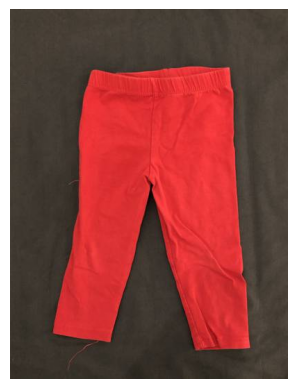

In [2]:
# Load an image
img = Image.open('data/clothing-dataset-small/train/pants/0a7e5fe0-d592-40e6-b9b8-75aac9a2d685.jpg')

# Helper to visualize an image
def show_image(img, show_axis=False):
    plt.imshow(img)
    if not show_axis:
        plt.axis('off')
        plt.show()

# Visualize the image img
show_image(img)

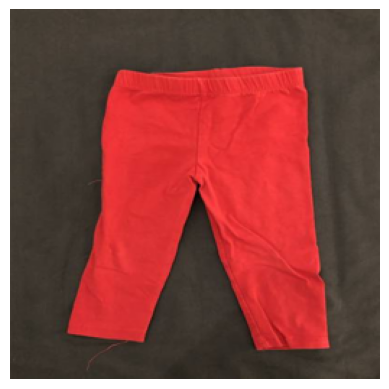

In [3]:
## Resize to target size
img = img.resize((256, 256))
show_image(img)

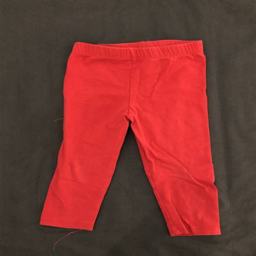

In [4]:
# Pillow images can also be shown directly
img

In [5]:
# Convert to a numpy array
x = np.array(img)
x.shape

(256, 256, 3)

In [6]:
x

array([[[73, 66, 56],
        [72, 65, 55],
        [71, 64, 54],
        ...,
        [75, 67, 56],
        [76, 68, 57],
        [78, 70, 59]],

       [[72, 65, 55],
        [71, 64, 54],
        [71, 64, 54],
        ...,
        [75, 67, 56],
        [76, 68, 57],
        [78, 70, 59]],

       [[71, 64, 54],
        [70, 63, 53],
        [70, 63, 53],
        ...,
        [74, 66, 55],
        [75, 67, 56],
        [77, 69, 58]],

       ...,

       [[60, 53, 45],
        [56, 49, 41],
        [55, 48, 40],
        ...,
        [62, 54, 45],
        [59, 51, 42],
        [59, 51, 42]],

       [[59, 52, 44],
        [55, 48, 40],
        [55, 48, 40],
        ...,
        [57, 50, 40],
        [55, 49, 39],
        [60, 53, 43]],

       [[58, 51, 43],
        [55, 48, 40],
        [54, 47, 39],
        ...,
        [55, 48, 38],
        [55, 48, 38],
        [59, 52, 42]]], shape=(256, 256, 3), dtype=uint8)

## 3. Pre-trained Models

We'll use a model pre-trained on ImageNet (1.4M images, 1000 classes).

Advantage of using pre-trained models:

- Already learned to recognize edges, textures, shapes
- Saves training time
- Works well even with small datasets
- Better performance than training from scratch

#### Using MobileNetV2

Load pre-trained model

In [7]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval() # Means the model will be used for evaluation only

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Set up the preprocessor for MobileNetV2

In [8]:
preprocess = transforms.Compose([
    transforms.Resize(226),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
preprocess(img)

tensor([[[-0.9020, -0.9192, -0.9363,  ..., -0.8507, -0.8335, -0.8164],
         [-0.9192, -0.9192, -0.9192,  ..., -0.8335, -0.8335, -0.8164],
         [-0.9192, -0.9192, -0.9192,  ..., -0.7822, -0.7822, -0.7650],
         ...,
         [-1.1760, -1.1760, -1.1760,  ..., -0.9192, -0.9705, -1.0048],
         [-1.1589, -1.1760, -1.1760,  ..., -0.9363, -1.0048, -1.0733],
         [-1.1760, -1.1589, -1.1589,  ..., -0.9877, -1.0733, -1.1418]],

        [[-0.9153, -0.9328, -0.9503,  ..., -0.8803, -0.8627, -0.8452],
         [-0.9328, -0.9328, -0.9328,  ..., -0.8627, -0.8627, -0.8452],
         [-0.9328, -0.9328, -0.9328,  ..., -0.8102, -0.8102, -0.7927],
         ...,
         [-1.1954, -1.1954, -1.1954,  ..., -0.9678, -1.0203, -1.0553],
         [-1.1779, -1.1954, -1.1954,  ..., -0.9853, -1.0378, -1.1078],
         [-1.1954, -1.1779, -1.1779,  ..., -1.0028, -1.0903, -1.1604]],

        [[-0.8633, -0.8807, -0.8981,  ..., -0.8458, -0.8284, -0.8110],
         [-0.8807, -0.8807, -0.8807,  ..., -0

Predict

In [10]:
# Get and transform the image to use for a prediction
img = Image.open('data/clothing-dataset-small/train/pants/1ca03195-b1e8-4c47-85de-81a942ea561e.jpg')
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0) # Creates batch(es?) of images
batch_t.shape

torch.Size([1, 3, 224, 224])

In [11]:
# Make prediction
with torch.no_grad():           # Means for evaluation only, no model creation
    output = model(batch_t)

output

tensor([[ 1.6927e+00, -3.6052e+00,  8.0802e-01,  1.2382e+00,  3.3269e-01,
         -1.3861e-02, -3.2112e-01, -4.0002e+00, -5.5007e+00, -4.1721e+00,
         -1.9657e+00, -2.3827e+00, -3.4390e+00, -2.3177e+00, -2.2882e+00,
         -2.8383e+00, -2.8985e+00, -1.1255e+00, -2.8063e+00, -6.4647e-01,
         -2.9870e+00, -1.8974e+00, -2.6893e+00, -2.6680e+00, -4.1820e+00,
         -4.0013e+00, -2.0177e+00, -5.2608e+00, -3.9280e+00, -6.2586e-01,
         -2.9468e+00, -5.6805e+00, -3.3333e+00, -1.4785e-01,  4.6562e+00,
         -8.9489e-02,  1.4705e+00, -1.3326e+00, -3.0048e+00, -3.3001e-01,
         -2.2319e+00, -3.8215e+00, -2.8025e+00, -2.4458e+00, -1.6874e+00,
         -3.9479e+00, -2.7201e+00, -6.0258e-02,  2.1805e-01,  2.0574e+00,
          1.7364e+00,  3.0380e+00, -1.5874e+00, -3.7977e+00, -4.6744e-01,
         -3.4774e+00, -2.8016e+00, -4.4211e+00, -2.6526e+00, -1.9859e+00,
         -1.0071e+00, -9.4132e-01, -1.2981e+00,  1.3034e+00, -1.1657e-01,
         -2.3233e+00,  1.0450e+00, -2.

In [12]:
print(output)

tensor([[ 1.6927e+00, -3.6052e+00,  8.0802e-01,  1.2382e+00,  3.3269e-01,
         -1.3861e-02, -3.2112e-01, -4.0002e+00, -5.5007e+00, -4.1721e+00,
         -1.9657e+00, -2.3827e+00, -3.4390e+00, -2.3177e+00, -2.2882e+00,
         -2.8383e+00, -2.8985e+00, -1.1255e+00, -2.8063e+00, -6.4647e-01,
         -2.9870e+00, -1.8974e+00, -2.6893e+00, -2.6680e+00, -4.1820e+00,
         -4.0013e+00, -2.0177e+00, -5.2608e+00, -3.9280e+00, -6.2586e-01,
         -2.9468e+00, -5.6805e+00, -3.3333e+00, -1.4785e-01,  4.6562e+00,
         -8.9489e-02,  1.4705e+00, -1.3326e+00, -3.0048e+00, -3.3001e-01,
         -2.2319e+00, -3.8215e+00, -2.8025e+00, -2.4458e+00, -1.6874e+00,
         -3.9479e+00, -2.7201e+00, -6.0258e-02,  2.1805e-01,  2.0574e+00,
          1.7364e+00,  3.0380e+00, -1.5874e+00, -3.7977e+00, -4.6744e-01,
         -3.4774e+00, -2.8016e+00, -4.4211e+00, -2.6526e+00, -1.9859e+00,
         -1.0071e+00, -9.4132e-01, -1.2981e+00,  1.3034e+00, -1.1657e-01,
         -2.3233e+00,  1.0450e+00, -2.

In [13]:
output.shape

torch.Size([1, 1000])

Obs: This means there is 1 image and 1000 predictions (1 per class).

In [14]:
# Get top predictions
_, indices = torch.sort(output, descending=True)    # Indices sorted from highest to lowest likelihood probability
indices

tensor([[608, 524, 474, 834, 461, 777, 630, 774, 457, 655, 806, 502, 638, 597,
         464, 697, 465, 652, 787, 911, 894, 643, 596, 824, 615, 885, 514, 906,
         678, 490, 456, 439, 715, 658, 451, 584, 869, 897, 764, 499, 459, 523,
         568, 639, 796, 473, 903, 684, 836, 600, 837, 861, 763, 589, 501, 512,
         795, 413, 636, 676, 552, 788, 748, 883, 395, 842, 578, 735, 718, 696,
         689, 623, 435, 545, 731, 462,  34, 518, 515, 419, 587, 804, 416, 601,
         546, 566, 785, 708, 770, 888, 420, 693, 876, 606, 841, 999, 792, 839,
         857, 674, 327, 583, 910, 769, 385, 896, 801, 570, 632, 399, 761, 641,
         366, 432, 233, 884, 618, 917, 843, 445, 593, 752, 865, 480, 494, 197,
         477, 902, 145, 877, 863, 880, 414, 851, 471, 893, 442,  51, 472, 169,
         778, 786, 539, 683, 835, 402, 529, 101, 493, 112, 370, 875, 610, 479,
         513, 122, 319, 895, 899, 713, 542, 148, 799, 850, 183, 577, 242, 534,
         771, 487, 691, 726, 840, 889, 904, 753, 433

In [15]:
print(indices)

tensor([[608, 524, 474, 834, 461, 777, 630, 774, 457, 655, 806, 502, 638, 597,
         464, 697, 465, 652, 787, 911, 894, 643, 596, 824, 615, 885, 514, 906,
         678, 490, 456, 439, 715, 658, 451, 584, 869, 897, 764, 499, 459, 523,
         568, 639, 796, 473, 903, 684, 836, 600, 837, 861, 763, 589, 501, 512,
         795, 413, 636, 676, 552, 788, 748, 883, 395, 842, 578, 735, 718, 696,
         689, 623, 435, 545, 731, 462,  34, 518, 515, 419, 587, 804, 416, 601,
         546, 566, 785, 708, 770, 888, 420, 693, 876, 606, 841, 999, 792, 839,
         857, 674, 327, 583, 910, 769, 385, 896, 801, 570, 632, 399, 761, 641,
         366, 432, 233, 884, 618, 917, 843, 445, 593, 752, 865, 480, 494, 197,
         477, 902, 145, 877, 863, 880, 414, 851, 471, 893, 442,  51, 472, 169,
         778, 786, 539, 683, 835, 402, 529, 101, 493, 112, 370, 875, 610, 479,
         513, 122, 319, 895, 899, 713, 542, 148, 799, 850, 183, 577, 242, 534,
         771, 487, 691, 726, 840, 889, 904, 753, 433

Let's see what's inside.

In [16]:
# Load ImageNet class names
imagenet_classes_file = 'data/clothing-dataset-small/imagenet_classes.txt'

with open(imagenet_classes_file, 'r') as f:
    categories = [s.strip() for s in f.readlines()]

# Get the top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_indices = [categories[i] for i in top5_indices]

print('Top 5 predictions:')
for i, class_name in enumerate(top5_indices):
    print(f'{1 + 1}: {class_name}')

Top 5 predictions:
2: jean
2: cuirass
2: cardigan
2: suit
2: breastplate


Key concepts:

- Input size: MobileNetV2 expects 224×224 images (Xception uses 299×299)
- Normalization: Images scaled with ImageNet mean and std
- Batch size: Number of images processed together
- Batch dimension: Shape (batch_size, channels, height, width) - e.g., (1, 3, 224, 224)

## 4. Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are specialized neural networks for processing grid-like data such as images.

Key Components:

1. Convolutional Layer: Extracts features using filters

    - Applies filters (e.g., 3×3, 5×5) to detect patterns
    - Creates feature maps (one per filter)
    - Detects edges, textures, shapes

2. ReLU Activation: Introduces non-linearity

    - f(x) = max(0, x)
    - Sets negative values to 0
    - Helps network learn complex patterns

3. Pooling Layer: Down-samples feature maps

    - Reduces spatial dimensions
    - Max pooling: takes maximum value in a region
    - Makes features more robust to small translations

4. Fully Connected (Dense) Layer: Final classification

    - Flattens 2D feature maps to 1D vector
    - Connects to output classes

CNN Workflow:

`Input Image → Conv + ReLU → Pooling → Conv + ReLU → Pooling → Flatten → Dense → Output`

## 5. Transfer Learning

Transfer Learning reuses a model trained on one task (e.g., ImageNet) for a different task (e.g., clothing classification).

Approach:

1. Load pre-trained model (feature extractor)
2. Remove original classification head
3. Freeze convolutional layers
4. Add custom layers for our task
5. Train only the new layers

#### Custom Dataset Class

First, create a PyTorch `Dataset` to load images

In [24]:
class ClothingDataset(Dataset):

    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

#### Simple preprocessing

In [25]:
input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

#### Create DataLoaders

In [26]:
train_dataset = ClothingDataset(
    data_dir='data/clothing-dataset-small/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='data/clothing-dataset-small/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### Build the model

In [27]:
class ClothingClassifierMobileNet(nn.Module):

    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)

        return x

#### Train the model

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiating the model
model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

# Defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Actual training

In [32]:
# Helper: train and evaluation function

def train_and_evaluation(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):

    # Training loop
    for epoch in range(num_epochs):

        # Training phase
        model.train()       # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over the training data
        for inputs, labels in train_loader:

            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero to parameter gradients to prevent accumulation
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()        # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Disable gradient calculation for validation
        with torch.no_grad():

            # Iterate over the validation data
            for inputs, labels in val_loader:

                # Move data to the specified device (GPUor CPU)
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                val_loss += loss.item()

                # Get predictions
                _, predicted = torch.max(outputs.data, 1)

                # Update total and correct predictions
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Print epoch results
        print(f'Epoch: {epoch + 1}/{num_epochs}:')
        print(f'    Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
        print(f'    Validation Loss: {val_loss:4f}, Validation Accuracy: {val_acc:.4f}')

**Observations**:

- PyTorch being a lower-level framework some manual implementations, such as calculating accuracy on validation, are needed.

- `optimizer.zero_grad()` is crucial in the training loop.

  In PyTorch, gradients are accumulated by default. This means that if they're not zeroed before calculating the gradients for the current batch, the gradients from the previous batch will be added to the gradients of the current batch. This would lead to incorrect updates to the model's parameters. By calling `optimizer.zero_grad()`, the old gradients are cleared out, ensuring that the gradients calculated during the `loss.backward()` call are only based on the current batch of data. This is essential for the optimizer to take the correct step during `optimizer.step()`.

- `model.train()` and `model.eval()` are needed to manage the behavior of certain layers during training and evaluation.

    - `model.train()` sets the model to training mode. In training mode, layers, such as Dropout and BatchNorm, behave differently. Dropout layers are active (randomly dropping neurons), and BatchNorm layers update their running statistics (mean and variance) based on the current batch.

    - `model.eval()` sets the model to evaluation mode. In evaluation mode, Dropout layers are inactive (they pass through all neurons), and BatchNorm layers use their accumulated running statistics instead of the current batch statistics. This ensures consistent behavior during inference and prevents randomness from affecting the evaluation results.

In [35]:
num_epochs = 10

In [33]:
# Call the custom function train_and_evaluation
train_and_evaluation(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch: 1/10:
    Training Loss: 0.6266, Training Accuracy: 0.8038
    Validation Loss: 0.613946, Validation Accuracy: 0.8035
Epoch: 2/10:
    Training Loss: 0.5494, Training Accuracy: 0.8263
    Validation Loss: 0.586915, Validation Accuracy: 0.8094
Epoch: 3/10:
    Training Loss: 0.5005, Training Accuracy: 0.8432
    Validation Loss: 0.578556, Validation Accuracy: 0.8035
Epoch: 4/10:
    Training Loss: 0.4683, Training Accuracy: 0.8478
    Validation Loss: 0.558293, Validation Accuracy: 0.7918
Epoch: 5/10:
    Training Loss: 0.4369, Training Accuracy: 0.8625
    Validation Loss: 0.537752, Validation Accuracy: 0.8065
Epoch: 6/10:
    Training Loss: 0.4215, Training Accuracy: 0.8625
    Validation Loss: 0.540087, Validation Accuracy: 0.8152
Epoch: 7/10:
    Training Loss: 0.3922, Training Accuracy: 0.8742
    Validation Loss: 0.540963, Validation Accuracy: 0.7918
Epoch: 8/10:
    Training Loss: 0.3858, Training Accuracy: 0.8778
    Validation Loss: 0.546948, Validation Accuracy: 0.8123


**Observations:**

The best validation accuracy is 0.8152, corresponding to a training accuracy of 0.8625 at epoch 7/10.

## 6. Tuning the Learning Rate

The learning rate controls how much to update model weights during training. It's one of the most important hyperparameters.

Analogy: Reading speed

- Too fast: Skip details, poor understanding (may not converge)
- Too slow: Never finish the book (training takes too long)
- Just right: Good comprehension and efficiency

Experimentation approach:

1. Try multiple values: [0.0001, 0.001, 0.01, 0.1]
2. Train for a few epochs each
3. Compare validation accuracy
4. Choose the rate with best performance and smallest train/val gap

In [34]:
# Helper
def make_model(learning_rate=0.01):
    model = ClothingClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    return model, optimizer

Test different learning rates

In [36]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f'\nLearning rate: {lr} ===')
    model, optimizer = make_model(learning_rate=lr)
    train_and_evaluation(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


Learning rate: 0.0001 ===
Epoch: 1/10:
    Training Loss: 1.9510, Training Accuracy: 0.3396
    Validation Loss: 1.751037, Validation Accuracy: 0.4164
Epoch: 2/10:
    Training Loss: 1.5972, Training Accuracy: 0.5117
    Validation Loss: 1.464642, Validation Accuracy: 0.5513
Epoch: 3/10:
    Training Loss: 1.3710, Training Accuracy: 0.6027
    Validation Loss: 1.280722, Validation Accuracy: 0.6158
Epoch: 4/10:
    Training Loss: 1.2224, Training Accuracy: 0.6437
    Validation Loss: 1.151762, Validation Accuracy: 0.6540
Epoch: 5/10:
    Training Loss: 1.1081, Training Accuracy: 0.6943
    Validation Loss: 1.055721, Validation Accuracy: 0.6979
Epoch: 6/10:
    Training Loss: 1.0223, Training Accuracy: 0.7164
    Validation Loss: 0.985907, Validation Accuracy: 0.7185
Epoch: 7/10:
    Training Loss: 0.9534, Training Accuracy: 0.7409
    Validation Loss: 0.923054, Validation Accuracy: 0.7273
Epoch: 8/10:
    Training Loss: 0.8973, Training Accuracy: 0.7565
    Validation Loss: 0.879926, V

**Observations:**

The best learning rate is 0.001 (validation accuracy = 0.8152).

## 7. Model Checkpointing

Checkpointing saves the model during training to:

- Keep the best performing model
- Resume training if interrupted
- Avoid losing progress


Observations:
- PyTorch: manual saving is done in training loop
- Keras: uses ModelCheckpoint callback

Update the train function

In [37]:
# Helper: train and evaluation function

def train_and_evaluate_with_checkpointing(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):

    # Initialize a variable to track the best validation accuracy
    best_val_accuracy = 0.0

    # Training loop
    for epoch in range(num_epochs):

        # Training phase
        model.train()       # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over the training data
        for inputs, labels in train_loader:

            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero to parameter gradients to prevent accumulation
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            running_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()        # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Disable gradient calculation for validation
        with torch.no_grad():

            # Iterate over the validation data
            for inputs, labels in val_loader:

                # Move data to the specified device (GPUor CPU)
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                val_loss += loss.item()

                # Get predictions
                _, predicted = torch.max(outputs.data, 1)

                # Update total and correct predictions
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        # Print epoch results
        print(f'Epoch: {epoch + 1}/{num_epochs}:')
        print(f'    Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}')
        print(f'    Validation Loss: {val_loss:4f}, Validation Accuracy: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'mobilenet_v2_{epoch + 1:02d}_{val_acc:.3f}.pth' # Make the naming (_v3_, ... _v4_, etc.) configurable for each hyperparameter tuning.
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved at:\n {checkpoint_path}')

## 8. Adding Inner Layers

Intermediate dense layers can be added between feature extraction and output layers.

Update the class `ClothingClassifierMobileNet`

In [38]:
class ClothingClassifierMobileNet(nn.Module):

    def __init__(self, size_inner=100, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)         # New inner layer
        self.relu = nn.ReLU()                            # Activation function
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output_layer(x)

        return x

Update function `make_model`

In [39]:
def make_model(learning_rate=0.001, size_inner=100):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner
    )

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    return model, optimizer

Test different `size_inner` vlaues

In [ ]:
for size_inner in [10, 100, 1000]:
    print(f'\nsize_inner: {size_inner} ===')

    model, optimizer = make_model(learning_rate=0.001)
    train_and_evaluation(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

**Observations:**

Experiment with different sizes:

- Try: size_inner = [10, 100, 1000]
- Larger layers: more capacity, may overfit
- Smaller layers: faster, may underfit


Key points:

- Inner layer uses `ReLU` activation
- Output layer has no activation (logits)
- `CrossEntropyLoss` applies `softmax` internally

## 9. Dropout Regularization

Dropout randomly drops neurons during training to prevent overfitting.

How it works:

- Training: randomly set fraction of activations to 0
- Inference: use all neurons (dropout disabled automatically)
- Creates ensemble effect


Benefits:

- Prevents relying on specific features
- Forces learning robust patterns
- Reduces overfitting

Update the class `ClothingClassifierMobileNet`

In [40]:
class ClothingClassifierMobileNet(nn.Module):

    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)         # New inner layer
        self.relu = nn.ReLU()                            # Activation function
        self.dropout = nn.Dropout(droprate)              # Add dropout
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)                               # Apply dropout
        x = self.output_layer(x)

        return x

Update function `make_model`

In [42]:
def make_model(learning_rate=0.001,
               size_inner=100,
               droprate=0.2):

    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate
    )

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    return model, optimizer

Test `droprate`

In [ ]:
num_epochs = 50     # For the dropout, more training is needed.

for droprate in  [0.0, 0.2, 0.5, 0.8]:
    print(f'\ndroprate: {droprate} ===')

    model, optimizer = make_model(
        learning_rate=0.001,
        size_inner=100,
        droprate=droprate
    )
    train_and_evaluation(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

**Experimentation:**

- Try: droprate = [0.0, 0.2, 0.5, 0.8]
- Typical values: 0.2 to 0.5
- Higher dropout may need more training epochs

Curent case: best droprate is 0.2

## 10. Data Augmentation

Data Augmentation artificially increases dataset size by applying random transformations to training images.

Common transformations:

- Rotation
- Horizontal/vertical flipping
- Zooming (random cropping)
- Shifting
- Shearing

Important rules:

✅ Apply ONLY to training data
🚫 Never augment validation/test data

#### Augmented Training Transforms

In [43]:
# NB: This code needs to be place where preprocessing is done (?), right be executing ClothingData() and instantiating  train_loader and val_loader.

# Training transforms WITh augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),                        # Rotate by up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),                    # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms - NO augmentation, same as earlier
val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [ ]:
num_epochs = 50     # For the dropout, more training is needed.

print(f'\nData augmentation: ===')

model, optimizer = make_model(
    learning_rate=0.001,
    size_inner=100,
    droprate=0.2
)
train_and_evaluation(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

✅ **When to use augmentation:**

- Small datasets
- Risk of overfitting
- Images can appear in different orientations

💡 Tips:

- Choose augmentations that make sense for the case data
- Too much augmentation can hurt performance
- Usually, requires longer training (more epochs)
- If no improvement after ~20 epochs, should not be used

## 11. Using the Trained Model

#### Loading a Saved Model

In [ ]:
# Find best checkpoint
list_of_files = glob.glob('mobilenet_v2_*.pth')
latest_file = max(list_of_files, key=os.path.getctime)
print(f"Loading model from: {latest_file}")

# Load model
model = ClothingClassifierMobileNet(size_inner=32, droprate=0.2, num_classes=10)
model.load_state_dict(torch.load(latest_file))
model.to(device)
model.eval()

#### Making Predictions

In [ ]:
def preprocess_pytorch_style(X):
    # X: shape (1, 224, 224, 3), dtype=float32, values in [0, 255]
    X = X / 255.0

    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

    # Convert NHWC → NCHW (batch, height, width, channels → batch, channels, height, width)
    X = X.transpose(0, 3, 1, 2)

    # Normalize
    X = (X - mean) / std

    return X.astype(np.float32)

preprocessor = create_preprocessor(preprocess_pytorch_style, target_size=(224, 224))

# Predict from URL
url = 'http://bit.ly/mlbookcamp-pants'
X = preprocessor.from_url(url)
X = torch.Tensor(X).to(device)

with torch.no_grad():
    pred = model(X).cpu().numpy()[0]

classes = [
    "dress", "hat", "longsleeve", "outwear", "pants",
    "shirt", "shoes", "shorts", "skirt", "t-shirt"
]

result = dict(zip(classes, pred.tolist()))
print(result)

## 12. Exporting to ONNX

ONNX (Open Neural Network Exchange) is a format for model interoperability.

Benefits:

- Deploy on different platforms
- Use optimized runtimes (ONNX Runtime)
- Better inference performance
- Language-agnostic deployment

In [ ]:
# Create dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = "clothing_classifier_mobilenet_v2.onnx"

torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported to {onnx_path}")

## 13. Best Practices

1. Start with pre-trained models (transfer learning)
2. Freeze convolutional layers initially
3. Use appropriate normalization (match pre-training)
4. Experiment with one hyperparameter at a time
5. Monitor train/val gap for overfitting
6. Use checkpointing to save best models
7. Augment training data only, not validation
8. Train longer with dropout and augmentation
9. Use GPU when available: `torch.cuda.is_available()`